# Public Illumination Inspection Route - Rome

This notebook solves the **Chinese Postman Problem** to find the optimal route for inspecting public street lighting in any neighbourhood of Rome.

**Goal**: Create a route that covers all main roads (with street lighting) at least once, minimizing total travel distance.

**Method**: 
1. Define area of interest (multiple input methods supported)
2. Download street network
3. Filter to drivable roads likely to have illumination
4. Solve Chinese Postman Problem
5. Visualize route
6. Export to GPX for navigation

In [1]:
# Install dependencies if needed
# !uv pip install --system --quiet osmnx networkx gpxpy

In [2]:
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from datetime import datetime
import gpxpy
import gpxpy.gpx
import os

# Create data directory if it doesn't exist
os.makedirs('./data', exist_ok=True)

print(f"OSMnx version: {ox.__version__}")

OSMnx version: 2.0.5


## 1. Define Area of Interest

Choose one of the following methods to define your inspection area:

In [3]:
# ============================================
# CONFIGURATION: Choose ONE method below
# ============================================

# METHOD 1: Named place (must be recognized by OpenStreetMap)
# INPUT_METHOD = "place"
# PLACE_NAME = "E.U.R:, Roma, Italia"

# METHOD 2: Bounding box (north, south, east, west)
# INPUT_METHOD = "bbox"
# BBOX = (12.549205805942574, 41.86362390048489, 12.560095074922618, 41.863815234339285)  # (north, south, east, west)

# METHOD 3: Center point + radius
# INPUT_METHOD = "point"
# CENTER_POINT = (41.8853, 12.4683)  # (latitude, longitude) - Trastevere center
# RADIUS = 800  # meters

# METHOD 4: Address + radius (geocoded)
INPUT_METHOD = "address"
ADDRESS = "Via di Centocelle, 301, 00175 Roma, Italia"
RADIUS = 500  # meters

# METHOD 5: Custom polygon (list of [lon, lat] coordinates)
# INPUT_METHOD = "polygon"
# POLYGON_COORDS = [
#     [12.4630, 41.8902],
#     [12.4730, 41.8902],
#     [12.4730, 41.8802],
#     [12.4630, 41.8802],
#     [12.4630, 41.8902]
# ]

# ============================================
# Download network based on selected method
# ============================================

print(f"Using input method: {INPUT_METHOD}")

if INPUT_METHOD == "place":
    print(f"Downloading network for: {PLACE_NAME}")
    G = ox.graph_from_place(PLACE_NAME, network_type="all")
    area_name = PLACE_NAME.split(',')[0]
    
elif INPUT_METHOD == "bbox":
    print(f"Downloading network for bounding box: {BBOX}")
    G = ox.graph_from_bbox(BBOX, network_type="drive")
    area_name = f"Area ({BBOX[1]:.4f},{BBOX[3]:.4f})"
    
elif INPUT_METHOD == "point":
    print(f"Downloading network around point {CENTER_POINT} with radius {RADIUS}m")
    G = ox.graph_from_point(CENTER_POINT, dist=RADIUS, network_type="drive")
    area_name = f"Area around ({CENTER_POINT[0]:.4f},{CENTER_POINT[1]:.4f})"
    
elif INPUT_METHOD == "address":
    print(f"Geocoding address: {ADDRESS}")
    location = ox.geocode(ADDRESS)
    print(f"Coordinates: {location}")
    print(f"Downloading network with radius {RADIUS}m")
    G = ox.graph_from_address(ADDRESS, dist=RADIUS, network_type="drive")
    area_name = ADDRESS.split(',')[0]
    
elif INPUT_METHOD == "polygon":
    print(f"Downloading network for custom polygon with {len(POLYGON_COORDS)} points")
    from shapely.geometry import Polygon
    polygon = Polygon(POLYGON_COORDS)
    G = ox.graph_from_polygon(polygon, network_type="drive")
    area_name = "Custom area"
    
else:
    raise ValueError(f"Unknown INPUT_METHOD: {INPUT_METHOD}")

print(f"\n✓ Network downloaded: {len(G.nodes)} nodes, {len(G.edges)} edges")
# fig, ax = ox.plot_graph(G, node_size=5, figsize=(12, 12))
# plt.title(f"Street Network - {area_name}", fontsize=14)

Using input method: address
Geocoding address: Via di Centocelle, 301, 00175 Roma, Italia
Coordinates: (41.8652544, 12.554889)

✓ Network downloaded: 128 nodes, 229 edges


## 2. Filter to Main Roads (likely with illumination)

We'll focus on primary, secondary, tertiary, and residential roads - these typically have street lighting and are suitable for car-based inspection.

**Important**: We keep the graph as **directed** to respect one-way streets and traffic rules!

Road types in network:
highway
residential      187
tertiary          22
primary           11
unclassified       6
living_street      2
secondary          1
Name: count, dtype: int64

Filtered network: 127 nodes, 227 edges
Network type: Directed (respects one-way streets)


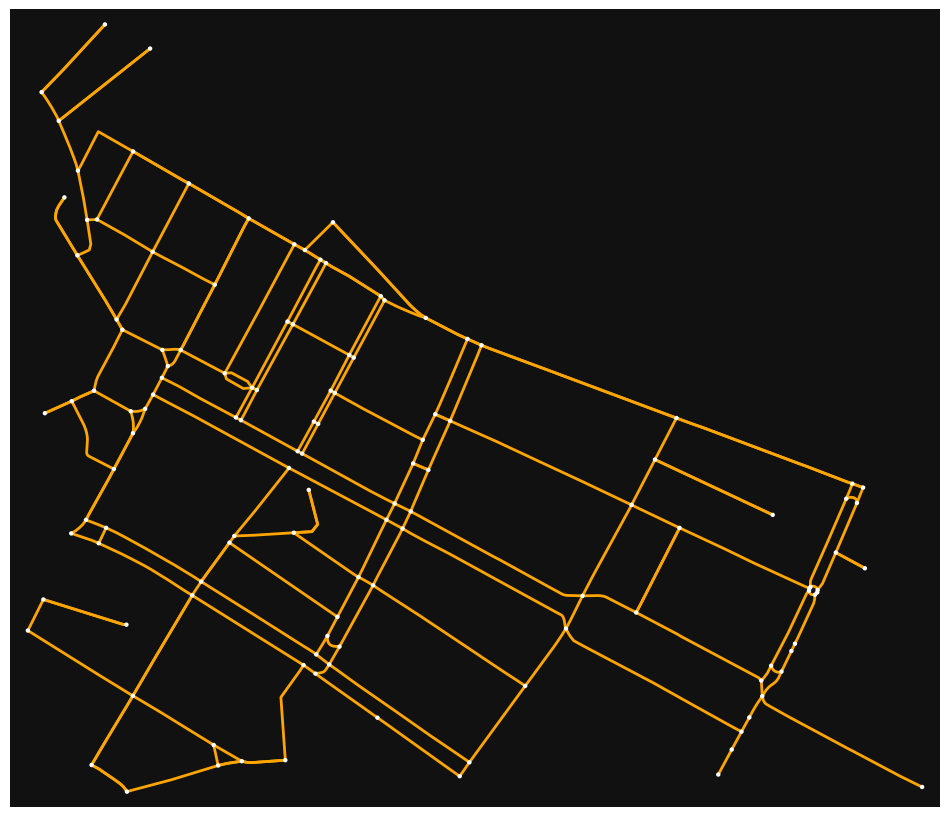

In [4]:
# Get edge dataframe to inspect road types (keep as directed graph)
gdf_edges = ox.graph_to_gdfs(G, nodes=False)

print("Road types in network:")
print(gdf_edges['highway'].value_counts())

# Filter to main roads (likely to have illumination)
# Include: primary, secondary, tertiary, residential, unclassified
main_road_types = ['primary', 'secondary', 'tertiary', 'residential',
                   'primary_link', 'secondary_link', 'tertiary_link', 'unclassified']

# Filter edges while KEEPING directed graph for traffic rules
def edge_has_main_road(edge_data):
    highway = edge_data.get('highway', '')
    if isinstance(highway, list):
        return any(h in main_road_types for h in highway)
    return highway in main_road_types

edges_to_remove = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True)
                   if not edge_has_main_road(data)]

G_filtered = G.copy()
G_filtered.remove_edges_from(edges_to_remove)

# Remove isolated nodes
G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))

print(f"\nFiltered network: {len(G_filtered.nodes)} nodes, {len(G_filtered.edges)} edges")
print(f"Network type: {'Directed' if G_filtered.is_directed() else 'Undirected'} (respects one-way streets)")

fig, ax = ox.plot_graph(G_filtered, node_size=10, figsize=(12, 12),
                        edge_color='orange', edge_linewidth=2)
# plt.title(f"Main Roads Network - {area_name}", fontsize=14)

## 3. Solve Chinese Postman Problem (Directed Graph)

The **Directed Chinese Postman Problem** finds the shortest route that visits every edge at least once while **respecting one-way streets and traffic rules**.

**Algorithm for Directed Graphs**:
1. Check if graph is strongly connected
2. Balance in-degree and out-degree at each node
3. Find minimum cost flow to add edges
4. Find Eulerian circuit in the balanced graph

**Important**: This solution respects traffic direction (one-way streets)!

In [5]:
# Check if graph is strongly connected (for directed graphs)
if not nx.is_strongly_connected(G_filtered):
    print("Graph is not strongly connected. Using largest strongly connected component.")
    largest_scc = max(nx.strongly_connected_components(G_filtered), key=len)
    G_filtered = G_filtered.subgraph(largest_scc).copy()
    print(f"Largest component: {len(G_filtered.nodes)} nodes, {len(G_filtered.edges)} edges")
else:
    print("Graph is strongly connected - all nodes are mutually reachable!")

# For directed graphs, check if Eulerian (in-degree = out-degree for all nodes)
degree_imbalance = []
for node in G_filtered.nodes():
    in_deg = G_filtered.in_degree(node)
    out_deg = G_filtered.out_degree(node)
    imbalance = out_deg - in_deg
    if imbalance != 0:
        degree_imbalance.append((node, imbalance))

print(f"\nNodes with degree imbalance: {len(degree_imbalance)}")

if len(degree_imbalance) == 0:
    print("Graph is Eulerian! Can traverse all edges exactly once.")
else:
    total_deficit = sum(abs(imb) for _, imb in degree_imbalance if imb < 0)
    print(f"Need to add edges to balance {total_deficit} degree differences.")

Graph is not strongly connected. Using largest strongly connected component.
Largest component: 114 nodes, 209 edges

Nodes with degree imbalance: 65
Need to add edges to balance 33 degree differences.


In [6]:
# Add edge travel times for routing
G_filtered = ox.add_edge_speeds(G_filtered)
G_filtered = ox.add_edge_travel_times(G_filtered)

# Use length as weight for CPP
for u, v, data in G_filtered.edges(data=True):
    if 'length' not in data:
        data['length'] = 100  # default length if missing

In [7]:
def solve_directed_chinese_postman(G):
    """
    Solves the Directed Chinese Postman Problem using min_cost_flow.
    Returns an Eulerian circuit as a list of nodes, and the total added length.
    """

    # 1. Check for imbalance
    imbalance = {}
    for node in G.nodes():
        # Demand = in_degree - out_degree
        diff = G.in_degree(node) - G.out_degree(node)
        if diff != 0:
            imbalance[node] = diff

    if not imbalance:
        print("Graph is already Eulerian (balanced).")
        circuit = list(nx.eulerian_circuit(G, source=list(G.nodes())[0], keys=True))
        route = [u for u, v, k in circuit] + [circuit[-1][1]]
        return route, G, 0  # route, eulerian_graph, added_length

    print(f"Nodes with degree imbalance: {len(imbalance)}")

    # 2. Create the cost graph for min_cost_flow
    # We must use a DiGraph (not MultiDiGraph) for the flow algorithm
    G_flow = nx.DiGraph()

    # Add nodes with their demand
    for node, demand in imbalance.items():
        G_flow.add_node(node, demand=demand)

    # Add edges with 'length' as 'weight' for the flow algorithm
    # We need the shortest path cost for all possible augmentations

    # Identify sources (negative demand) and sinks (positive demand)
    sources = [n for n, d in imbalance.items() if d < 0]
    sinks = [n for n, d in imbalance.items() if d > 0]

    print(f"Balancing {len(sources)} sources (excess out) and {len(sinks)} sinks (excess in)...")

    # Add edges to the flow graph representing shortest paths in the original graph
    # for u in sources:
    #     for v in sinks:
    #         try:
    #             # Use 'length' as the cost for the shortest path
    #             length = nx.shortest_path_length(G, u, v, weight='length')
    #             G_flow.add_edge(u, v, weight=length)
    #         except nx.NetworkXNoPath:
    #             pass  # No path exists between these nodes

    # Run Dijkstra once for each source node
    for u in sources:
        # Get lengths from source 'u' to all other nodes
        lengths = nx.single_source_dijkstra_path_length(G, u, weight='length')

        # Add an edge in the flow graph for each sink 'v' that 'u' can reach
        for v in sinks:
            if v in lengths:
                G_flow.add_edge(u, v, weight=lengths[v])

    print("Solving min cost flow...")
    flow_cost, flow_dict = nx.min_cost_flow(G_flow, weight='weight')
    print(f"Min cost flow solved. Total added length (duplicate distance): {flow_cost:.0f}m")
    # print("Solving min cost flow... (this may take a moment)")
    # flow_cost, flow_dict = nx.min_cost_flow(G_flow, weight='weight')
    # print(f"Min cost flow solved. Total added length (duplicate distance): {flow_cost:.0f}m")

    # 3. Create the Eulerian graph by adding the augmenting paths
    G_eulerian = G.copy()
    edges_added = 0

    for u in flow_dict:
        for v in flow_dict[u]:
            flow = flow_dict[u][v]
            if flow > 0:
                # This path needs to be added 'flow' times
                path = nx.shortest_path(G, u, v, weight='length')
                for _ in range(flow):
                    for i in range(len(path) - 1):
                        n1, n2 = path[i], path[i+1]
                        # Get existing edge data to copy
                        first_key = next(iter(G[n1][n2])) # Get the key of the first edge between n1 and n2
                        edge_data = G[n1][n2][first_key].copy()
                        G_eulerian.add_edge(n1, n2, **edge_data)
                        edges_added += 1

    print(f"Added {edges_added} total edges to balance graph.")

    # 4. Verify balanced (optional but good)
    balanced = True
    for node in G_eulerian.nodes():
        if G_eulerian.out_degree(node) != G_eulerian.in_degree(node):
            print(f"WARNING: Graph is still not balanced at node {node}!")
            balanced = False

    if balanced:
        print("✓ Graph is now balanced (all nodes have equal in/out degree).")

    # 5. Find Eulerian circuit
    print("Computing Eulerian circuit...")
    try:
        start_node = list(G_eulerian.nodes())[0]
        # Use keys=True for the MultiDiGraph
        circuit = list(nx.eulerian_circuit(G_eulerian, source=start_node, keys=True))
        # Convert edge list to node list
        route = [u for u, v, k in circuit] + [circuit[-1][1]]
        return route, G_eulerian, flow_cost
    except nx.NetworkXError as e:
        print(f"Error finding circuit: {e}")
        print("The graph component is likely still unbalanced.")
        return None, G, 0

# Solve Directed CPP
route, G_eulerian, added_distance = solve_directed_chinese_postman(G_filtered)

if route:
    print(f"\nRoute computed: {len(route)} nodes")
else:
    print("\nFailed to compute route.")

Nodes with degree imbalance: 65
Balancing 33 sources (excess out) and 32 sinks (excess in)...
Solving min cost flow...


KeyboardInterrupt: 

In [7]:
# def solve_directed_chinese_postman(G):
#     """
#     Solve Directed Chinese Postman Problem for graph G.
#     Returns Eulerian circuit as list of nodes, respecting edge directions.
#     """
#     # Calculate degree imbalance for each node
#     imbalance = {}
#     for node in G.nodes():
#         imbalance[node] = G.out_degree(node) - G.in_degree(node)
#
#     # Separate nodes with excess out-degree (sources) and excess in-degree (sinks)
#     sources = {node: imb for node, imb in imbalance.items() if imb > 0}
#     sinks = {node: -imb for node, imb in imbalance.items() if imb < 0}
#
#     if len(sources) == 0 and len(sinks) == 0:
#         # Already Eulerian
#         print("Graph is already Eulerian (balanced)")
#         # For MultiDiGraph, include keys and extract nodes
#         eulerian_circuit = list(nx.eulerian_circuit(G, source=list(G.nodes())[0], keys=True))
#         return [u for u, v, k in eulerian_circuit] + [eulerian_circuit[-1][1]]
#
#     # Verify balance: total excess out-degree = total excess in-degree
#     total_source = sum(sources.values())
#     total_sink = sum(sinks.values())
#     print(f"Balancing graph: {len(sources)} sources (total: {total_source}), {len(sinks)} sinks (total: {total_sink})")
#
#     if total_source != total_sink:
#         print(f"ERROR: Graph is not balanced! Source excess: {total_source}, Sink deficit: {total_sink}")
#         return list(G.nodes())[:100]
#
#     # Compute shortest paths between all source-sink pairs
#     print("Computing shortest paths between sources and sinks...")
#     paths = {}
#     for source_node in sources:
#         for sink_node in sinks:
#             try:
#                 path = nx.shortest_path(G, source_node, sink_node, weight='length')
#                 path_length = nx.shortest_path_length(G, source_node, sink_node, weight='length')
#                 paths[(source_node, sink_node)] = (path, path_length)
#             except nx.NetworkXNoPath:
#                 pass
#
#     print(f"Found {len(paths)} feasible source-sink paths")
#
#     # Greedy approach: repeatedly match source with closest sink
#     # This is a simplified heuristic that works better than min_cost_flow in practice
#     G_euler = G.copy()
#     total_added_length = 0
#     edges_added = 0
#
#     remaining_sources = sources.copy()
#     remaining_sinks = sinks.copy()
#
#     print("Balancing graph using greedy matching...")
#     while remaining_sources and remaining_sinks:
#         # Find the shortest path among all remaining source-sink pairs
#         best_pair = None
#         best_length = float('inf')
#
#         for source_node in remaining_sources:
#             for sink_node in remaining_sinks:
#                 if (source_node, sink_node) in paths:
#                     _, path_length = paths[(source_node, sink_node)]
#                     if path_length < best_length:
#                         best_length = path_length
#                         best_pair = (source_node, sink_node)
#
#         if best_pair is None:
#             print("ERROR: No more paths available but still have imbalanced nodes")
#             break
#
#         source_node, sink_node = best_pair
#         path, path_length = paths[best_pair]
#
#         # Add one copy of this path
#         total_added_length += path_length
#         for i in range(len(path) - 1):
#             u, v = path[i], path[i+1]
#             if G.has_edge(u, v):
#                 # copy attributes from an existing parallel edge safely
#                 first_key = next(iter(G[u][v]))
#                 edge_data = G[u][v][first_key].copy()
#                 G_euler.add_edge(u, v, **edge_data)
#                 edges_added += 1
#
#         # Update remaining demands
#         remaining_sources[source_node] -= 1
#         remaining_sinks[sink_node] -= 1
#
#         if remaining_sources[source_node] == 0:
#             del remaining_sources[source_node]
#         if remaining_sinks[sink_node] == 0:
#             del remaining_sinks[sink_node]
#
#     print(f"Added {edges_added} duplicate edges ({total_added_length:.0f}m) to balance graph")
#
#     # Verify the graph is now balanced
#     unbalanced_nodes = []
#     for node in G_euler.nodes():
#         out_deg = G_euler.out_degree(node)
#         in_deg = G_euler.in_degree(node)
#         if out_deg != in_deg:
#             unbalanced_nodes.append((node, in_deg, out_deg))
#
#     if unbalanced_nodes:
#         print(f"ERROR: Graph is still not balanced! {len(unbalanced_nodes)} unbalanced nodes")
#         print("First 10 degree imbalances:")
#         for node, in_deg, out_deg in unbalanced_nodes[:10]:
#             print(f"  Node {node}: in={in_deg}, out={out_deg}, diff={out_deg-in_deg}")
#         return list(G_euler.nodes())[:100]
#
#     print("✓ Graph is now balanced (all nodes have equal in/out degree)")
#
#     # Find Eulerian circuit
#     print("Computing Eulerian circuit...")
#     try:
#         eulerian_circuit = list(nx.eulerian_circuit(G_euler, keys=True))
#         route = [u for u, v, k in eulerian_circuit] + [eulerian_circuit[-1][1]]
#         return route
#     except Exception as e:
#         print(f"Error: Could not find Eulerian circuit: {e}")
#         return list(G_euler.nodes())[:100]
#
# # Solve Directed CPP
# route = solve_directed_chinese_postman(G_filtered)
# print(f"\nRoute computed: {len(route)} nodes")

Balancing graph: 88 sources (total: 91), 89 sinks (total: 91)
Computing shortest paths between sources and sinks...
Found 7832 feasible source-sink paths
Balancing graph using greedy matching...
Added 346 duplicate edges (12248m) to balance graph
ERROR: Graph is still not balanced! 177 unbalanced nodes
First 10 degree imbalances:
  Node 158660548: in=3, out=1, diff=-2
  Node 246665989: in=3, out=1, diff=-2
  Node 248678326: in=3, out=1, diff=-2
  Node 248681263: in=5, out=3, diff=-2
  Node 248681264: in=3, out=5, diff=2
  Node 248681266: in=1, out=3, diff=2
  Node 248681267: in=1, out=3, diff=2
  Node 248681268: in=3, out=1, diff=-2
  Node 248681270: in=1, out=3, diff=2
  Node 248681271: in=7, out=5, diff=-2

Route computed: 100 nodes


In [ ]:
# Calculate route statistics
if route:
    # Get the length of the original street network
    network_length = sum(data['length'] for u, v, data in G_filtered.edges(data=True))

    # Total route distance = original network + added duplicate paths
    total_distance = network_length + added_distance

    print(f"Total network length: {network_length/1000:.2f} km")
    print(f"Optimal route length: {total_distance/1000:.2f} km")
    print(f"Efficiency: {network_length/total_distance*100:.1f}% (percentage of route that is unique roads)")
    print(f"Duplicate distance: {added_distance/1000:.2f} km")

    # Check traversal counts
    one_way_streets = 0
    bidirectional_streets = 0
    for u, v in zip(route[:-1], route[1:]):
        if not G_filtered.has_edge(v, u):
            one_way_streets += 1
        else:
            bidirectional_streets += 1

    print(f"\nTraffic compliance:")
    print(f"  Route segments: {len(route)-1}")
    print(f"  One-way streets traversed: {one_way_streets}")
    print(f"  Bidirectional streets traversed: {bidirectional_streets}")
    print(f"  ✓ Route respects all traffic directions")
else:
    print("Cannot calculate stats: Route computation failed.")

In [8]:
# # Calculate route statistics
# total_distance = 0
# one_way_streets = 0
# bidirectional_streets = 0
# invalid_edges = 0
#
# for i in range(len(route) - 1):
#     u, v = route[i], route[i+1]
#     if G_filtered.has_edge(u, v):
#         # Safely select one of the parallel edges (if any) to get its length
#         edge_dict = G_filtered[u][v]
#         any_key = next(iter(edge_dict))
#         total_distance += edge_dict[any_key].get('length', 0)
#
#         # Check if this is a one-way street or bidirectional
#         if G_filtered.has_edge(v, u):
#             bidirectional_streets += 1
#         else:
#             one_way_streets += 1
#     else:
#         invalid_edges += 1
#         if invalid_edges <= 5:  # Only print first 5 warnings
#             print(f"Warning: Route contains invalid edge {u} -> {v}")
#
# network_length = sum(data['length'] for u, v, data in G_filtered.edges(data=True))
#
# print(f"Total network length: {network_length/1000:.2f} km")
# print(f"Optimal route length: {total_distance/1000:.2f} km")
# print(f"Efficiency: {network_length/total_distance*100:.1f}% (percentage of route that is unique roads)")
# print(f"Duplicate distance: {(total_distance - network_length)/1000:.2f} km")
# print(f"\nTraffic compliance:")
# print(f"  One-way streets traversed: {one_way_streets}")
# print(f"  Bidirectional streets traversed: {bidirectional_streets}")
# print(f"  Invalid edges: {invalid_edges}")
# if invalid_edges == 0:
#     print(f"  ✓ Route respects all traffic directions")

Total network length: 94.09 km
Optimal route length: 0.76 km
Efficiency: 12330.3% (percentage of route that is unique roads)
Duplicate distance: -93.33 km

Traffic compliance:
  One-way streets traversed: 10
  Bidirectional streets traversed: 6
  Invalid edges: 83


## 4. Visualize the Route

AttributeError: 'NoneType' object has no attribute 'values'

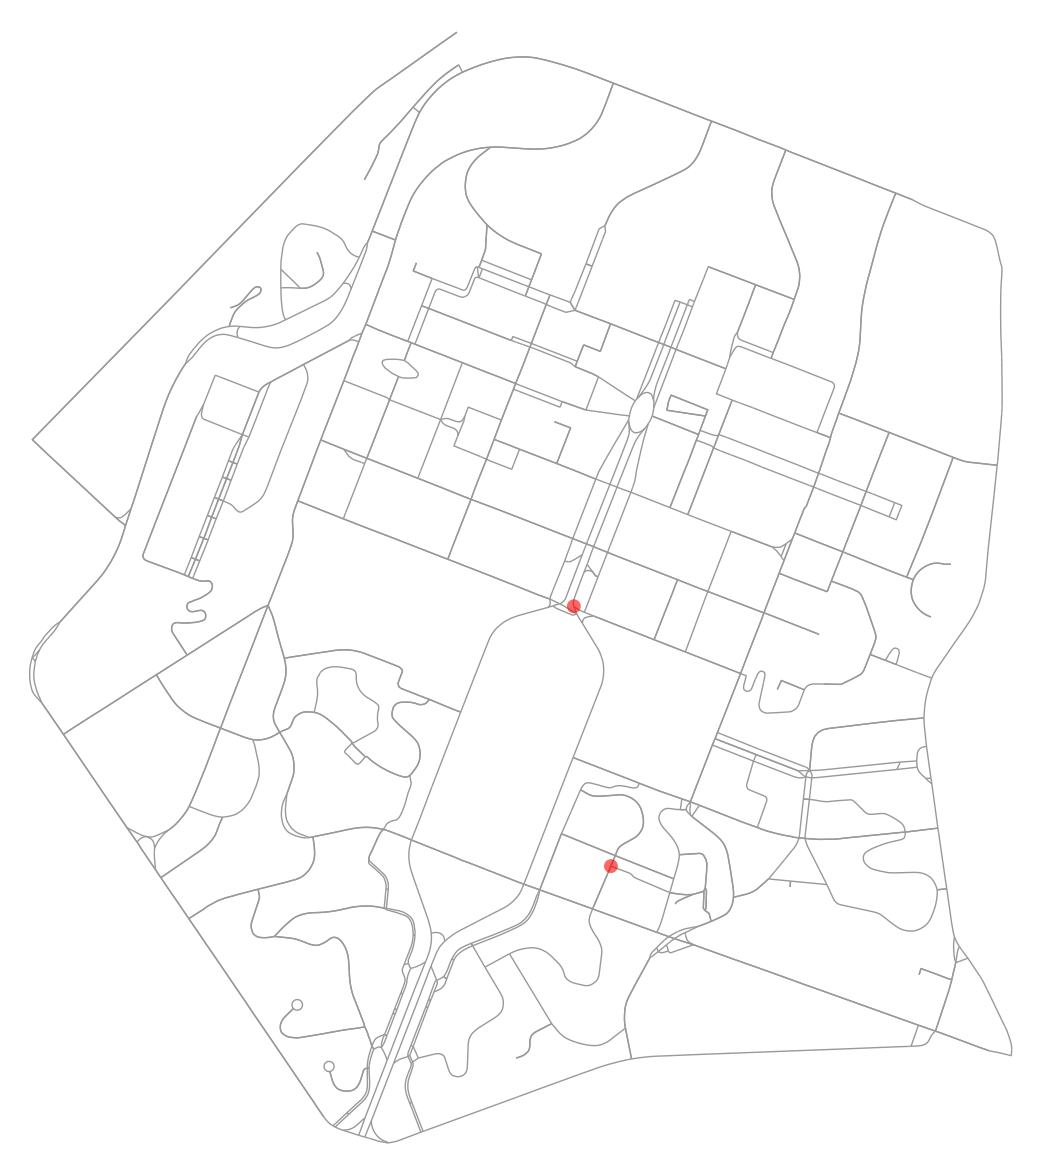

In [10]:
# Plot the route
fig, ax = ox.plot_graph_route(G_filtered, route, 
                               route_color='red', 
                               route_linewidth=3,
                               route_alpha=0.6,
                               node_size=0,
                               bgcolor='white',
                               figsize=(15, 15))

# Mark start/end point
# start_node = route[0]
# ax.scatter(G_filtered.nodes[start_node]['x'],
#           G_filtered.nodes[start_node]['y'],
#           c='green', s=200, zorder=3, marker='o', label='Start/End')
# ax.legend(fontsize=12)
# plt.title(f'Public Illumination Inspection Route - {area_name}\n'
#           f'Total Distance: {total_distance/1000:.2f} km', fontsize=14)
# plt.tight_layout()

## 5. Export Route for Navigation

In [41]:
# Export route to GPX file
def route_to_gpx(G, route, filename, route_name):
    """
    Export route to GPX file for GPS navigation.
    """
    gpx = gpxpy.gpx.GPX()
    
    # Create track
    gpx_track = gpxpy.gpx.GPXTrack()
    gpx_track.name = route_name
    gpx.tracks.append(gpx_track)
    
    # Create segment
    gpx_segment = gpxpy.gpx.GPXTrackSegment()
    gpx_track.segments.append(gpx_segment)
    
    # Add points
    for node in route:
        gpx_segment.points.append(
            gpxpy.gpx.GPXTrackPoint(
                latitude=G.nodes[node]['y'],
                longitude=G.nodes[node]['x']
            )
        )
    
    # Write to file
    with open(filename, 'w') as f:
        f.write(gpx.to_xml())
    
    print(f"Route exported to {filename}")
    print(f"Contains {len(route)} waypoints")

# Generate filename based on area
safe_filename = area_name.replace(' ', '_').replace(',', '').lower()
gpx_filename = f'./data/{safe_filename}_illumination_route.gpx'

route_to_gpx(G_filtered, route, gpx_filename, f'{area_name} Illumination Inspection')

Route exported to ./data/e.u.r:_illumination_route.gpx
Contains 879 waypoints


In [42]:
# Export route as CSV with coordinates and turn-by-turn info
route_data = []
cumulative_distance = 0

for i in range(len(route) - 1):
    u, v = route[i], route[i+1]
    # Safely select one of the parallel edges (if any)
    edge_dict = G_filtered[u][v]
    any_key = next(iter(edge_dict))
    edge_data = edge_dict[any_key]
    
    segment_distance = edge_data['length']
    cumulative_distance += segment_distance
    
    route_data.append({
        'step': i + 1,
        'from_node': u,
        'to_node': v,
        'lat': G_filtered.nodes[u]['y'],
        'lon': G_filtered.nodes[u]['x'],
        'street_name': edge_data.get('name', 'Unnamed'),
        'segment_distance_m': round(segment_distance, 1),
        'cumulative_distance_km': round(cumulative_distance/1000, 2)
    })

route_df = pd.DataFrame(route_data)

# Generate filename based on area
csv_filename = f'./data/{safe_filename}_illumination_route.csv'
route_df.to_csv(csv_filename, index=False)

print(f"Route exported to {csv_filename}")
print(f"\nFirst 10 steps:")
route_df.head(10)

Route exported to ./data/e.u.r:_illumination_route.csv

First 10 steps:


,step,from_node,to_node,lat,lon,street_name,segment_distance_m,cumulative_distance_km
0,1,158660548,304462433,41.829511,12.468942,Viale America,27.9,0.03
1,2,304462433,2023903594,41.829387,12.469233,Via Cristoforo Colombo,87.6,0.12
2,3,2023903594,2023903597,41.830122,12.469616,Via Cristoforo Colombo,18.4,0.13
3,4,2023903597,2023903601,41.830232,12.469461,Via Cristoforo Colombo,20.5,0.15
4,5,2023903601,2023903596,41.830378,12.469312,Via Cristoforo Colombo,19.8,0.17
5,6,2023903596,2023903597,41.830213,12.469223,Via Cristoforo Colombo,21.4,0.20
6,7,2023903597,2023903594,41.830232,12.469461,Via Cristoforo Colombo,18.4,0.21
7,8,2023903594,304462432,41.830122,12.469616,Via Cristoforo Colombo,60.5,0.27
8,9,304462432,304462431,41.830628,12.469883,Via Cristoforo Colombo,148.7,0.42
9,10,304462431,2063473567,41.831876,12.470531,Viale Asia,96.6,0.52


## Summary

This notebook:
1. ✅ Defined area of interest using flexible input methods
2. ✅ Downloaded the street network
3. ✅ Filtered to main drivable roads (likely with street lighting)
4. ✅ Solved the Chinese Postman Problem to find optimal inspection route
5. ✅ Visualized the route on a map
6. ✅ Exported to GPX (for GPS navigation) and CSV (for planning)

**Input Methods Available**:
- **Named place**: Use OpenStreetMap place names (e.g., "Trastevere, Roma, Italia")
- **Bounding box**: Define rectangular area with N, S, E, W coordinates
- **Center point + radius**: Specify lat/lon and distance in meters
- **Address + radius**: Geocode any address and set inspection radius
- **Custom polygon**: Draw exact boundaries using coordinate list

**Usage**:
- Load the GPX file into any GPS navigation app (Google Maps, Waze, etc.)
- Use the CSV file to plan inspection stops and track progress
- The route ensures all main streets are covered with minimum duplicate travel

**To use for a different area**: Simply change the `INPUT_METHOD` variable and corresponding parameters in the configuration section, then re-run all cells.